In [2]:
import json
import pandas as pd

In [3]:
# Load df from CSV
df = pd.read_csv("../assets/outputs/bbch_df.csv", parse_dates=['date'])

print(df.shape)
df.head()

(4652, 29)


,date,station,depth,op,mean_sst,mean_airt,SSM,SST,year,doy,...,VH,VV,angle,lc,BASE_TEMP,cum_GDD_air,cum_GDD_soil,cum_GDD,BBCH,cum_SSM
0,2015-04-25,MB1,0 to 5 cm,0,10.166667,7.8365,0.131444,14.981481,2015,115,...,-20.0,-13.0,40.0,146,5,2.8365,5.166667,4.001583,0.0,0.131444
1,2015-04-25,MB10,0 to 5 cm,0,7.516667,7.8385,0.432889,12.637037,2015,115,...,-27.0,-20.0,43.0,146,5,5.6750,7.683333,6.679167,0.0,0.564333
2,2015-04-25,MB11,0 to 5 cm,0,8.616667,8.3805,0.273259,12.581481,2015,115,...,-22.0,-14.0,42.0,158,10,5.6750,7.683333,6.679167,0.0,0.837593
3,2015-04-25,MB12,0 to 5 cm,0,5.350000,8.0125,0.311259,14.271247,2015,115,...,-22.0,-12.0,42.0,146,5,8.6875,8.033333,8.360417,0.0,1.148852
4,2015-04-25,MB2,0 to 5 cm,0,13.270938,8.3070,0.340557,15.961012,2015,115,...,-19.0,-9.0,40.0,146,5,11.9945,16.304271,14.149386,0.0,1.489409


In [4]:
# Load it back as a dict
with open("../assets/config/gdd/crop_data_final_sorted.json", "r") as f:
    crop_data_final_sorted_loaded = json.load(f)
    print(crop_data_final_sorted_loaded)

{'133': {'bbch_k_b': [[0, 80, 1], [10, 70, 5], [20, 30, 30], [50, 10, 50], [75, 15, 60], [100, 1, 70]]}, '136': {'bbch_k_b': [[0, 80, 1], [10, 70, 5], [20, 30, 30], [50, 10, 50], [75, 15, 60], [100, 1, 70]]}, '146': {'bbch_k_b': [[0, 80, 1], [10, 70, 5], [20, 30, 30], [50, 10, 50], [75, 15, 60], [100, 1, 70]]}, '147': {'bbch_k_b': [[0, 100, 1], [10, 80, 5], [20, 50, 30], [40, 30, 50], [60, 20, 60], [80, 10, 70], [100, 1, 80]]}, '153': {'bbch_k_b': [[0, 40, 1], [10, 20, 5], [20, 40, 25], [40, 20, 70], [60, 22, 95], [80, 20, 100], [100, 15, 110]]}, '157': {'bbch_k_b': [[0, 100, 1], [10, 80, 5], [20, 50, 30], [40, 30, 50], [60, 20, 60], [80, 10, 70], [100, 1, 80]]}, '158': {'bbch_k_b': [[0, 40, 1], [10, 20, 5], [20, 40, 25], [40, 20, 70], [60, 22, 95], [80, 20, 100], [100, 15, 110]]}, '167': {'bbch_k_b': [[0, 40, 1], [10, 20, 5], [20, 40, 25], [40, 20, 70], [60, 22, 95], [80, 20, 100], [100, 15, 110]]}}


In [5]:
# Load crop_bounds back as a dict
with open("../assets/config/crop_bounds.json", "r") as f:
    crop_bounds_loaded = json.load(f)
    print(crop_bounds_loaded)

{'133': {'cbound': [0, 0.1, 0.5], 'sbound': [0, 0.025, 0.5], 'lbound': [0, 0.075, 0.5], 'wbound': [0, 0.1, 0.5]}, '136': {'cbound': [0, 0.1, 0.5], 'sbound': [0, 0.025, 0.5], 'lbound': [0, 0.075, 0.5], 'wbound': [0, 0.1, 0.5]}, '146': {'cbound': [0, 0.1, 0.5], 'sbound': [0, 0.025, 0.5], 'lbound': [0, 0.075, 0.5], 'wbound': [0, 0.1, 0.5]}, '147': {'cbound': [0, 0.1, 0.5], 'sbound': [0, 0.025, 0.5], 'lbound': [0, 0.075, 0.5], 'wbound': [0, 0.1, 0.5]}, '153': {'cbound': [0, 0.1, 0.5], 'sbound': [0, 0.025, 0.5], 'lbound': [0, 0.075, 0.5], 'wbound': [0, 0.1, 0.5]}, '157': {'cbound': [0, 0.1, 0.5], 'sbound': [0, 0.025, 0.5], 'lbound': [0, 0.075, 0.5], 'wbound': [0, 0.1, 0.5]}, '158': {'cbound': [0, 0.1, 0.5], 'sbound': [0, 0.025, 0.5], 'lbound': [0, 0.075, 0.5], 'wbound': [0, 0.1, 0.5]}, '167': {'cbound': [0, 0.1, 0.5], 'sbound': [0, 0.025, 0.5], 'lbound': [0, 0.075, 0.5], 'wbound': [0, 0.1, 0.5]}}


In [6]:
from inversion import Inverse

# Set the bacscattering models
RT_models = {
    'RT_s': 'PRISM1', # options: 'AIEM', 'PRISM1'
    'RT_c': 'Diff' # options: 'Diffuse', 'Specular'
}

inv = Inverse(fGHz=5.405, models=RT_models, acftype='exp', crop_bbch_k_b_coff=crop_data_final_sorted_loaded)
inv_df = inv.run(df, crop_bounds_loaded)

/home/morteza/usask/inversion/.venv/lib/python3.11/site-packages/ssrt/core.py:58: RuntimeWarning: invalid value encountered in divide
  self.eps_ratio = eps3 / eps2
/home/morteza/usask/inversion/.venv/lib/python3.11/site-packages/ssrt/utils/fresnel.py:16: RuntimeWarning: invalid value encountered in divide
  gamma0 = np.abs((1 - sqrt_eps) / (1 + sqrt_eps)) ** 2
/home/morteza/usask/inversion/.venv/lib/python3.11/site-packages/ssrt/utils/fresnel.py:64: RuntimeWarning: invalid value encountered in divide
  sin_theta_ratio = (n1 * sin_theta) / n2
/home/morteza/usask/inversion/.venv/lib/python3.11/site-packages/ssrt/utils/fresnel.py:67: RuntimeWarning: invalid value encountered in divide
  rho_v = -(n2 * np.cos(theta_rad) - n1 * costh2) / (n2 * np.cos(theta_rad) + n1 * costh2)
/home/morteza/usask/inversion/.venv/lib/python3.11/site-packages/ssrt/utils/fresnel.py:68: RuntimeWarning: invalid value encountered in divide
  rho_h =  (n1 * np.cos(theta_rad) - n2 * costh2) / (n1 * np.cos(theta_rad

In [7]:
print(inv_df.shape)
inv_df.head()

(4533, 37)


,date,station,depth,op,mean_sst,mean_airt,SSM,SST,year,doy,...,BBCH,cum_SSM,d,c,w,vvv,vvs,s,l,rvi
0,2015-04-25,MB1,0 to 5 cm,0,10.166667,7.8365,0.131444,14.981481,2015,115,...,0.0,0.131444,0.542216,0.223872,0.038168,-15.143286,-17.094702,0.002778,0.075,0.665350
1,2015-04-25,MB10,0 to 5 cm,0,7.516667,7.8385,0.432889,12.637037,2015,115,...,0.0,0.564333,0.542231,0.299723,0.016292,-22.702143,-23.342004,0.000855,0.075,0.665350
2,2015-04-25,MB11,0 to 5 cm,0,8.616667,8.3805,0.273259,12.581481,2015,115,...,0.0,0.837593,0.229865,0.388830,0.000165,-17.824103,-16.325193,0.002802,0.075,0.547228
3,2015-04-25,MB12,0 to 5 cm,0,5.350000,8.0125,0.311259,14.271247,2015,115,...,0.0,1.148852,0.300340,0.295478,0.000311,-15.626653,-14.470647,0.003304,0.075,0.363636
4,2015-04-25,MB2,0 to 5 cm,0,13.270938,8.3070,0.340557,15.961012,2015,115,...,0.0,1.489409,0.300859,0.235370,0.000298,-12.332148,-11.710666,0.004548,0.075,0.363636


In [8]:
inv_df.to_csv("../assets/outputs/inv_df.csv", index=False)

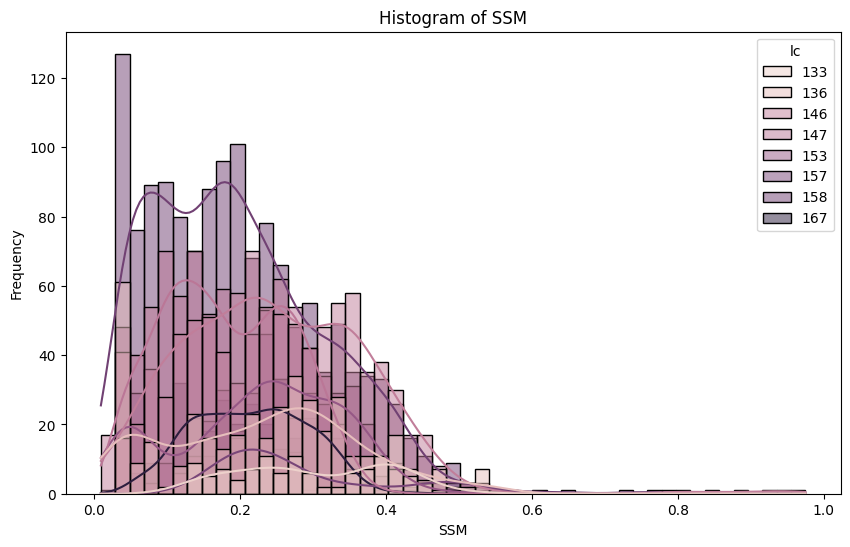

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'gp_merged' DataFrame is already created as in the provided code.

plt.figure(figsize=(10, 6))
sns.histplot(inv_df, x='SSM', kde=True, hue='lc')
plt.title('Histogram of SSM')
plt.xlabel('SSM')
plt.ylabel('Frequency')
plt.show()

/tmp/ipykernel_4616/369816459.py:13: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[i].legend(loc='upper left', bbox_to_anchor=(1, 1))


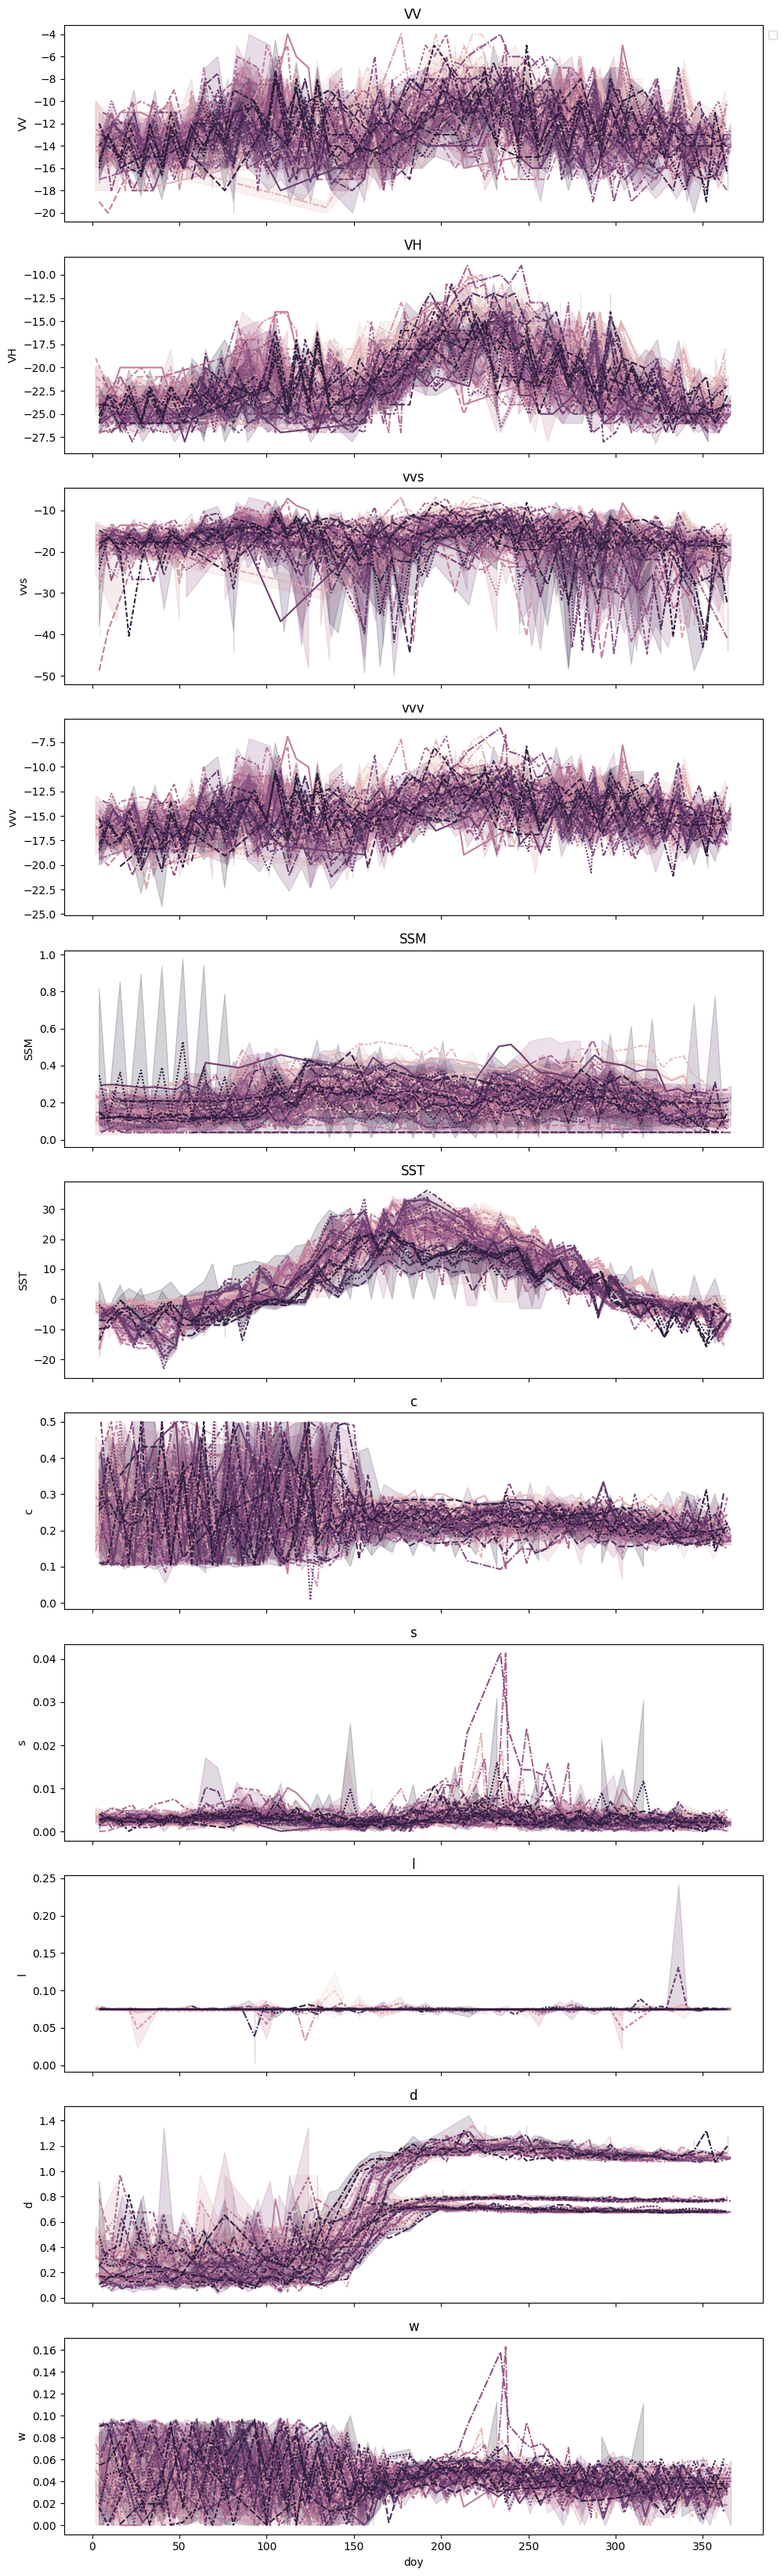

In [10]:
# Assuming 'gp_merged' DataFrame is already created as in the provided code.

parameters = ['VV', 'VH', 'vvs', 'vvv', 'SSM', 'SST', 'c', 's', 'l', 'd', 'w']
num_parameters = len(parameters)

fig, axes = plt.subplots(num_parameters, 1, figsize=(10, 3 * num_parameters), sharex=True)

for i, param in enumerate(parameters):
    sns.lineplot(ax=axes[i], x='doy', y=param, data=inv_df, hue='year', style='lc', legend=False)
    axes[i].set_title(param)
    # Add legend only to the first subplot
    if i == 0:
        axes[i].legend(loc='upper left', bbox_to_anchor=(1, 1))

plt.tight_layout()
plt.show()